In [ ]:
!pip install contrastive

In [34]:
import numpy as np
import itertools
from scipy.special import comb
from scipy.linalg import subspace_angles
from scipy.optimize import minimize
from sklearn.cluster import SpectralClustering
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from contrastive import CPCA

In [35]:
def single_cPCA(X:np.ndarray, Y:np.ndarray, alpha, k):
    Cx = np.cov(X.T)
    Cy = np.cov(Y.T)

    C = Cx - alpha * Cy
    _, V = np.linalg.eigh(C)

    return V[:, -k:]

In [36]:
def affinity(combination, d, k):
    combination = combination.reshape(2, d, k)
    return np.prod(np.cos(subspace_angles(*combination)))

def v_affinity(combinations, d, k):
    return np.apply_along_axis(lambda combination: affinity(combination, d, k), 1, combinations)

In [37]:
def cPCA(X:np.ndarray, Y:np.ndarray, alpha_set, k, p):
    # check d value:
    assert X.shape[1] == Y.shape[1]

    d = X.shape[1]
    V_set = []

    # calculate cPCA for each alpha
    for alpha in alpha_set:
        V = single_cPCA(X, Y, alpha, k)
        V_set.append(V)
    V_set = np.array(V_set)

    # calculate affinity Matrix for each pair of Vs
    combination_indices = np.array(list(itertools.combinations_with_replacement(range(len(V_set)), 2)))
    combinations = V_set[combination_indices].reshape(len(combination_indices), 2 * d * k)
    aff = v_affinity(combinations, d, k)

    rows = combination_indices[:, 0]
    cols = combination_indices[:, 1]
    D = np.zeros((len(V_set), len(V_set)))
    D[rows, cols] = D[cols, rows] = aff

    # cluster Vs with respect to affinities
    clustering = SpectralClustering(n_clusters=p, affinity='precomputed').fit(D)

    # find best V and alpha in each cluster
    V_star = []
    alpha_star = []
    for cluster in range(p):
        cluster_members = np.where(clustering.labels_ == cluster)[0]
        sums = np.sum(D[cluster_members, :][:, cluster_members], axis=1)
        V_star.append(V_set[cluster_members[np.argmax(sums)]])
        alpha_star.append(alpha_set[cluster_members[np.argmax(sums)]])
    
    return alpha_star, V_star

In [88]:
def draw(texts, X, V_set, labels):
    transformed = []
    label_set = set(labels)
    
    for V in V_set:
        df = pd.DataFrame(data=X.dot(V), columns=['x', 'y'])
        df['label'] = labels
        transformed.append(df)

    fig = plt.figure(figsize=(4 * len(V_set), 4))

    colors = ['k','r','b','g','c']

    for i in range(len(V_set)):
        ax = fig.add_subplot(1, len(V_set), i + 1)
        ax.set_title(texts[i])
        ax.set_aspect('auto')

        j = 0
        for label in label_set:
            data = transformed[i][transformed[i].label == label]
            plt.scatter(data.x, data.y, color=colors[j%len(colors)], label=str(label))
            j += 1
        plt.legend()

In [85]:
N = 400; D = 30; gap=3
# In B, all the data pts are from the same distribution, which has different variances in three subspaces.
B = np.zeros((N, D))
B[:,0:10] = np.random.normal(0,10,(N,10))
B[:,10:20] = np.random.normal(0,3,(N,10))
B[:,20:30] = np.random.normal(0,1,(N,10))


# In A there are four clusters.
A = np.zeros((N, D))
A[:,0:10] = np.random.normal(0,10,(N,10))
# group 1
A[0:100, 10:20] = np.random.normal(0,1,(100,10))
A[0:100, 20:30] = np.random.normal(0,1,(100,10))
# group 2
A[100:200, 10:20] = np.random.normal(0,1,(100,10))
A[100:200, 20:30] = np.random.normal(gap,1,(100,10))
# group 3
A[200:300, 10:20] = np.random.normal(2*gap,1,(100,10))
A[200:300, 20:30] = np.random.normal(0,1,(100,10))
# group 4
A[300:400, 10:20] = np.random.normal(2*gap,1,(100,10))
A[300:400, 20:30] = np.random.normal(gap,1,(100,10))
A_labels = [0]*100+[1]*100+[2]*100+[3]*100

In [39]:
pca = PCA(n_components=2)

In [40]:
pca_transformed = pca.fit_transform(A)

In [41]:
pca_transformed_data = pd.DataFrame(pca_transformed, columns=['x', 'y'])
pca_transformed_data['label'] = A_labels
pca_transformed_data.head()

,x,y,label
0,0.009351,-2.075731,0
1,-8.525338,14.390449,0
2,-7.103317,-2.249077,0
3,2.247875,11.260173,0
4,9.017979,-1.451346,0


No handles with labels found to put in legend.


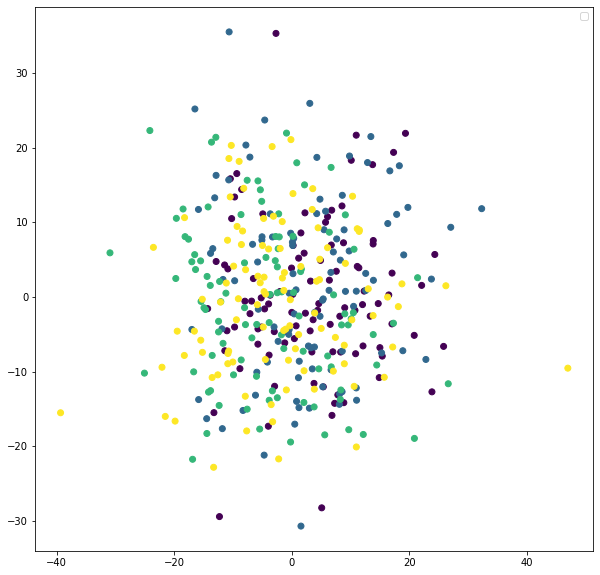

In [42]:
plt.figure(figsize=(10, 10))
plt.scatter(pca_transformed_data.x, pca_transformed_data.y, c=pca_transformed_data.label)
plt.legend()

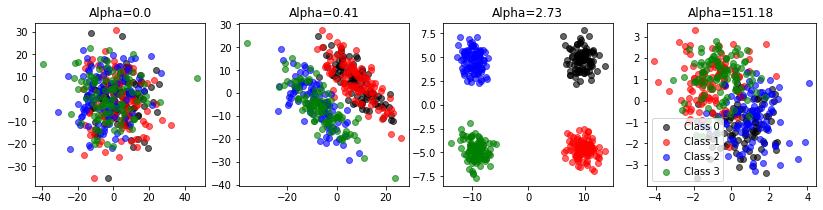

In [46]:
CPCA(standardize=False).fit_transform(A, B, plot=True, active_labels=A_labels)

In [53]:
alpha_star, V_star = cPCA(A, B, alpha_set=[0, 0.041, 2.73, 151.18, 1000, 10, 100, 15], k=2, p=4)

In [54]:
alpha_star

[151.18, 2.73, 0, 100]

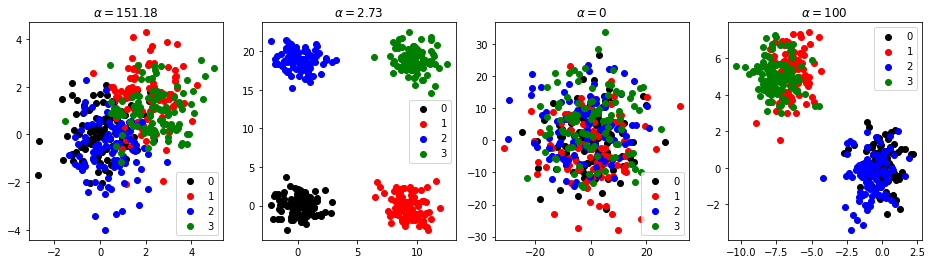

In [89]:
draw(
    texts=[f'$\\alpha = {alpha}$' for alpha in alpha_star],
    X=A,
    V_set=V_star,
    labels=A_labels
)